In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

# Methods

We defined a set of know facilitators based on literature and used these to train an ensemble of classifiers based on features from the high content microscopy screen (Table S2). This ensemble consisted of an L2 penalized logistic regression and a random forest classifier. The hyperparameter of the L2 regularization of the logistic regression was set using three-fold cross-validation. The random forest model was trained with 1000 trees and a maximum of 10 features. The final probability was calculated as the mean of the predicted probability of the two classifiers. The performance was assesed by the ROC AUC (0.757) and the Precision-Recall AUC (0.604) based on leave-one-out cross-validation.

In [5]:
# Here Table_S2.tsv is Table S2 in tab-separated flat text format
df = pd.read_table("Table_S2.tsv")
df.head()

,Plate,PLATE GENE NAME,SAL4pos - Number of Objects,Number of Objects,Area - Mean,Area - StdDev,Roundness - Mean,Roundness - StdDev,Width - Mean,Width - StdDev,...,SEr Dapi SER Valley 0 px - Mean,SEr Dapi SER Saddle 0 px - Mean,SEr Dapi SER Bright 0 px - Mean,SEr Dapi SER Dark 0 px - Mean,Haralick DAPI Haralick Correlation 1 px - Mean,Haralick DAPI Haralick Contrast 1 px - Mean,Haralick DAPI Haralick Sum Variance 1 px - Mean,Haralick DAPI Haralick Homogeneity 1 px - Mean,GABOR E Cadherin Gabor Min 2 px w2 - Mean,GABOR E Cadherin Gabor Max 2 px w2 - Mean
0,1.1,nt1,1.322409,1.120268,0.303996,-0.308210,1.438285,0.442811,0.861441,0.209616,...,0.189700,-0.028972,-0.246972,0.291115,-0.620633,0.487059,0.457001,0.343553,0.389142,0.451720
1,1.1,Trp53,0.568636,0.800992,0.433639,0.104059,0.205089,1.145923,0.176123,-0.098126,...,0.684103,0.852496,-0.000301,0.467951,0.088227,2.167899,2.314751,0.189394,-0.058073,-0.214945
2,1.1,Cbx7,-0.938910,1.758821,-0.602747,-0.418758,1.613784,-1.067860,-0.082724,-0.239205,...,0.658878,2.073668,1.175098,0.104015,0.453558,0.169073,-0.392763,-1.723230,-1.108887,-0.549870
3,1.1,Uchl5,-0.938910,1.865246,-1.612368,-1.356558,0.837188,0.660350,-1.467503,-1.333668,...,-0.701188,-0.167360,0.372276,-0.920072,-0.611528,-0.727522,-0.741339,-0.039792,-0.403897,-0.637796
4,1.1,Kmt2d,-0.185137,0.694566,-1.229019,-0.884952,1.470514,-0.147664,-0.598424,0.069010,...,0.043053,0.858901,0.466490,-0.115775,1.280963,-0.143585,-0.304780,-1.251962,-0.318812,-0.467254


In [6]:
facilitator = [
    "c-Myc", 
    "Chd1",
    "Ezh2",
    "Jarid2",
    "Jmjd1c",
    "Kdm2b",
    "Kdm3a",
    "Kdm5b",
    "Kdm6a", 
    "Ncoa3",
    "Parp1",
    "Pou5f1",
    "Snai1",
    "Tet1",
    "Wdr5",
]
barrier = [
    "Chaf1b",
    "Dnmt1",
    "Ehmt2",
    "Hdac2",
    "Kdm6b",
    "Mbd3",
    "Setdb1",
    "Snai2",
    "Suv39h1",
    "Suv39h2",
    "Tet2",
    "Trp53",
]
column_map = {
'Replicate ' : "Replicate",
'Plate' : "Plate",
'PLATE' : "Plate",

'GENE NAME' : "GENE NAME",
'PLATE GENE NAME' : "GENE NAME",
'WellName' : "Well",
'SAL4pos - Number of Objects' : "SAL4_no",
'SAL4pos  Area [µm²] - Mean per Well' : "SAL4_area",
'SAL4pos  Roundness - Mean per Well' : "SAL4_roundness",
' - Number of Objects' : "no",
'  Area [µm²] - Mean per Well' : "area_mean",
'  Area [µm²] - StdDev per Well' : "area_sd",
'  Roundness - Mean per Well' : "roundness_mean",
'  Roundness - StdDev per Well' : "roundness_sd",
'  Width [µm] - Mean per Well' : "width_mean",
'  Width [µm] - StdDev per Well' : "width_sd",
'  Length [µm] - Mean per Well' : "length_mean",
'  Length [µm] - StdDev per Well' : "length_sd",
'  Ratio Width to Length - Mean per Well' : "ratio_width_length_mean",
'  Ratio Width to Length - StdDev per Well' : "ratio_width_length_sd",
' - Intensity Dapi Image Region Exp1Cam1 Mean - Mean per Well' : "Intensity_Dapi_mean",
' - Intensity Dapi Image Region Exp1Cam1 Mean - StdDev per Well' : "Intensity_Dapi_sd",
' - Intensity Sall4 Image Region Exp1Cam2 Mean - Mean per Well' : "Intensity_Sall4_mean",
' - Intensity Sall4 Image Region Exp1Cam2 Mean - StdDev per Well' : "Intensity_Sall4_sd",
' - Intensity E-Cadherin Image Region Exp2Cam2 Mean - Mean per Well' : "Intensity_E-Cadherin_mean",
' - Intensity E-Cadherin Image Region Exp2Cam2 Mean - StdDev per Well' : "Intensity_E-Cadherin_sd",
' - Intensity Image Region_Ring around region Sal4 Mean - Mean per Well' : "Intensity_ring_Sall4_mean",
' - Intensity Image Region_Ring around region Sal4 Mean - StdDev per Well' : "Intensity_ring_Sall4_sd",
' - Intensity Image Region_Ring around region E cadherin Mean - Mean per Well' : "Intensity_ring_E-Cadherin_mean",
' - Intensity Image Region_Ring around region E cadherin Mean - StdDev per Well' : "Intensity_ring_E-Cadherin_sd",
' - SAL4 ratio - Mean per Well' : "SAL4_ratio",
' - E-CAD RATIO - Mean per Well' : "E-cad_ratio",
' - SAL4pos - Mean per Well' : "SAL4pos",
'  STAR Symmetry 02  - Mean per Well' : "STAR_Symm_02",
'  STAR Symmetry 03  - Mean per Well' : "STAR_Symm_03",
'  STAR Symmetry 04  - Mean per Well' : "STAR_Symm_04",
'  STAR Symmetry 05  - Mean per Well' : "STAR_Symm_05",
'  STAR Symmetry 12  - Mean per Well' : "STAR_Symm_12",
'  STAR Symmetry 13  - Mean per Well' : "STAR_Symm_13",
'  STAR Symmetry 14  - Mean per Well' : "STAR_Symm_14",
'  STAR Symmetry 15  - Mean per Well' : "STAR_Symm_15",
'  STAR Threshold Compactness 30%  - Mean per Well' : "STAR_compact_30%",
'  STAR Threshold Compactness 40%  - Mean per Well' : "STAR_compact_40%",
'  STAR Threshold Compactness 50%  - Mean per Well' : "STAR_compact_50%",
'  STAR Threshold Compactness 60%  - Mean per Well' : "STAR_compact_60%",
'  STAR Axial Small Length  - Mean per Well' : "STAR_Axial_Small_Length",
'  STAR Axial Length Ratio  - Mean per Well' : "STAR_Length_Ratio",
'  STAR Radial Mean  - Mean per Well' : "STAR_Radial_Mean",
'  STAR Radial Relative Deviation  - Mean per Well' : "START_Radial_Dev",
'  STAR Profile 4/5  - Mean per Well' : "STAR_Profile_4",
'  STAR Profile 5/5  - Mean per Well' : "STAR_Profile_5",
'  SEr Dapi SER Spot 0 px - Mean per Well' : "SER Spot",
'  SEr Dapi SER Hole 0 px - Mean per Well' : "SER Hole",
'  SEr Dapi SER Edge 0 px - Mean per Well' : "SER Edge",
'  SEr Dapi SER Ridge 0 px - Mean per Well' : "SER Ridge",
'  SEr Dapi SER Valley 0 px - Mean per Well' : "SER Valley",
'  SEr Dapi SER Saddle 0 px - Mean per Well' : "SER Saddle",
'  SEr Dapi SER Bright 0 px - Mean per Well' : "SER Bright",
'  SEr Dapi SER Dark 0 px - Mean per Well' : "SER Dark",
'  Haralick DAPI Haralick Correlation 1 px - Mean per Well' : "Haralick Correlation",
'  Haralick DAPI Haralick Contrast 1 px - Mean per Well' : "Haralick Contrast",
'  Haralick DAPI Haralick Sum Variance 1 px - Mean per Well' : "Haralick Sum Variance",
'  Haralick DAPI Haralick Homogeneity 1 px - Mean per Well' : "Haralick Homogeneity",
'  GABOR E Cadherin Gabor Min 2 px w2 - Mean per Well' : "Gabor Min 2",
'  GABOR E Cadherin Gabor Max 2 px w2 - Mean per Well' : "Gabor Max 2",
}

new_columns = [column_map.get(x,x) for x in df.columns]
df.columns = new_columns

df = df[~df["Plate"].isnull()]

df["Plate"] = df["Plate"].astype(str)
df.head()

,Plate,GENE NAME,SAL4_no,Number of Objects,Area - Mean,Area - StdDev,Roundness - Mean,Roundness - StdDev,Width - Mean,Width - StdDev,...,SEr Dapi SER Valley 0 px - Mean,SEr Dapi SER Saddle 0 px - Mean,SEr Dapi SER Bright 0 px - Mean,SEr Dapi SER Dark 0 px - Mean,Haralick DAPI Haralick Correlation 1 px - Mean,Haralick DAPI Haralick Contrast 1 px - Mean,Haralick DAPI Haralick Sum Variance 1 px - Mean,Haralick DAPI Haralick Homogeneity 1 px - Mean,GABOR E Cadherin Gabor Min 2 px w2 - Mean,GABOR E Cadherin Gabor Max 2 px w2 - Mean
0,1.1,nt1,1.322409,1.120268,0.303996,-0.308210,1.438285,0.442811,0.861441,0.209616,...,0.189700,-0.028972,-0.246972,0.291115,-0.620633,0.487059,0.457001,0.343553,0.389142,0.451720
1,1.1,Trp53,0.568636,0.800992,0.433639,0.104059,0.205089,1.145923,0.176123,-0.098126,...,0.684103,0.852496,-0.000301,0.467951,0.088227,2.167899,2.314751,0.189394,-0.058073,-0.214945
2,1.1,Cbx7,-0.938910,1.758821,-0.602747,-0.418758,1.613784,-1.067860,-0.082724,-0.239205,...,0.658878,2.073668,1.175098,0.104015,0.453558,0.169073,-0.392763,-1.723230,-1.108887,-0.549870
3,1.1,Uchl5,-0.938910,1.865246,-1.612368,-1.356558,0.837188,0.660350,-1.467503,-1.333668,...,-0.701188,-0.167360,0.372276,-0.920072,-0.611528,-0.727522,-0.741339,-0.039792,-0.403897,-0.637796
4,1.1,Kmt2d,-0.185137,0.694566,-1.229019,-0.884952,1.470514,-0.147664,-0.598424,0.069010,...,0.043053,0.858901,0.466490,-0.115775,1.280963,-0.143585,-0.304780,-1.251962,-0.318812,-0.467254


In [7]:
def get_median_x_y(df, kind="combine"):
    sum_df = df.groupby("GENE NAME").median().iloc[:, 1:]
    control = sum_df[sum_df.index.str.startswith("nt")]
    pos = sum_df[sum_df.index.isin(facilitator)]
    neg = sum_df[sum_df.index.isin(barrier)]

    effect = sum_df[sum_df.index.isin(facilitator + barrier)]
    if kind == "barrier":
        effect = sum_df[sum_df.index.isin(barrier)]
    elif kind == "facilitator":
        effect = sum_df[sum_df.index.isin(facilitator)]
    X = pd.concat((effect, control)).fillna(0)
    y = np.hstack((np.ones(effect.shape[0]), np.zeros(control.shape[0])))

    print X.shape[0], "training samples"
    
    print (sum(y) / y.shape)[0], "labeled as positive"
    return X, y

In [8]:
def get_all_x_y(df):
    pos = df[df["GENE NAME"].isin(facilitator)].iloc[:,4:]
    neg = df[df["GENE NAME"].isin(barrier)].iloc[:,4:]
    control = df[df["GENE NAME"].str.startswith("non").fillna(False)].iloc[:,4:]

    X = pd.concat((neg, control)).fillna(0)
    y = np.hstack((np.ones(neg.shape[0]), np.zeros(control.shape[0])))

    print X.shape
    print y.shape
    print sum(y) / y.shape
    return X, y

In [9]:
def loo_cv(X, y, model, img=None):
    loo = LeaveOneOut()
    y_preds = []
    y_probs = []
    y_true = []
    X_labels = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        if i % 10 == 0:
            print int(float(i) / X.shape[0] * 100),
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        y_preds = np.hstack((y_preds, y_pred))
        y_probs = np.hstack((y_probs, y_prob))
        y_true = np.hstack((y_true, y_test))
        X_labels += list(X.index[test_index])
    print
    print
    print "total"
    print "---> predicted"
    print "\t0\t1"
    for i,row in enumerate(confusion_matrix(y_true, y_preds)):
        print "{}\t{}\t{}".format(i, row[0], row[1])
    
    for x in np.array(X_labels)[y_preds.astype(bool)]:
        if not x.startswith("non"):
            print x
    
    return y_true, y_probs

In [10]:
X, y = get_median_x_y(df, kind="facilitator")
l = LogisticRegressionCV()
y_true_lr, y_pred_lr = loo_cv(X,y,l)
l.fit(X,y)
pd.DataFrame({"coef":l.coef_[0]}, index=X.columns).sort_values("coef").tail(10)


57 training samples
0.263157894737 labeled as positive
0 17 35 52 70 87

total
---> predicted
	0	1
0	38	4
1	9	6
Jarid2
Kdm6a
Pou5f1
Snai1
Tet1
c-Myc
nt11
nt25
nt34
nt8


,coef
STAR Threshold Compactness 30% - Mean,0.556983
SEr Dapi SER Spot 0 px - Mean,0.559374
SEr Dapi SER Ridge 0 px - Mean,0.612651
SAL4 ratio - Mean,0.664150
STAR Threshold Compactness 50% - Mean,0.722692
STAR Threshold Compactness 60% - Mean,0.947519
Width - StdDev,1.098949
Length - StdDev,1.110157
Haralick DAPI Haralick Contrast 1 px - Mean,1.238600
SEr Dapi SER Saddle 0 px - Mean,1.566240


In [11]:
X, y = get_median_x_y(df, kind="facilitator")
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, max_features=10)
y_true_rf, y_pred_rf = loo_cv(X,y,rf)
rf.fit(X,y)
pd.DataFrame({"importances":rf.feature_importances_}, index=X.columns).sort_values("importances").tail(10)


57 training samples
0.263157894737 labeled as positive
0 17 35 52 70 87

total
---> predicted
	0	1
0	41	1
1	11	4
Jarid2
Kdm6a
Pou5f1
Tet1
nt25


,importances
Width - Mean,0.029139
Area - StdDev,0.030196
SEr Dapi SER Hole 0 px - Mean,0.031306
GABOR E Cadherin Gabor Min 2 px w2 - Mean,0.032039
SEr Dapi SER Ridge 0 px - Mean,0.034222
SEr Dapi SER Bright 0 px - Mean,0.036482
SAL4pos - Mean,0.040382
Intensity _Ring around region Sal4 Mean - StdDev,0.041185
SEr Dapi SER Spot 0 px - Mean,0.044391
Number of Objects,0.049733


In [12]:
y_pred_mean = np.vstack((y_pred_lr, y_pred_rf)).mean(0)

fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_true_rf, y_pred_rf)
fpr_mean, tpr_mean, _ = roc_curve(y_true_lr, y_pred_mean)

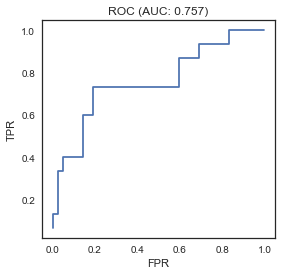

In [13]:
sns.set_style('white')
plt.plot(fpr_mean, tpr_mean);
plt.xlabel("FPR")
plt.ylabel("TPR")
roc_auc = roc_auc_score(y_true_lr, y_pred_mean)
plt.title("ROC (AUC: {:0.3f})".format(roc_auc))
plt.axes().set_aspect('equal')
plt.savefig("20180821_roc_curve.pdf")

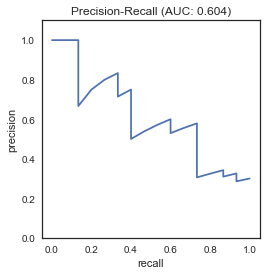

In [14]:
precision_lr, recall_lr, _ = precision_recall_curve(y_true_lr, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_true_rf, y_pred_rf)
precision_mean, recall_mean, _ = precision_recall_curve(y_true_rf, y_pred_mean)

sns.set_style('white')

plt.plot(recall_mean, precision_mean);
plt.xlabel("recall")
plt.ylabel("precision")
pr_auc = average_precision_score(y_true_rf, y_pred_mean)
plt.title("Precision-Recall (AUC: {:0.3f})".format(pr_auc))
plt.ylim(0,1.1)
plt.axes().set_aspect('equal')
plt.savefig("20180821_pr_curve.pdf")